In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import optimize
from scipy.optimize import Bounds

In [2]:
start, end = '2017-1-1', '2022-1-1'
ticker = '^STOXX'

In [3]:
index = yf.download(ticker, start, end)
index_close = index['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [4]:
average_market_ret = index_close.pct_change().mean() * 21
average_market_ret

0.005955463696412721

In [5]:
av_m = index_close.pct_change().mean() * 253

In [6]:
av_std = index_close.pct_change().std() * (253**0.5)

In [7]:
weekly_index = index_close.resample('1W').last().dropna()
average_weekly_index = weekly_index.pct_change().mean()
average_weekly_index

0.0014017543214283668

In [8]:
rf = pd.read_csv('wbond.csv')
rf_close = rf.Ultimo / 100
rf_close

0     -0.0071
1     -0.0067
2     -0.0067
3     -0.0079
4     -0.0080
        ...  
256   -0.0037
257   -0.0040
258   -0.0041
259   -0.0041
260   -0.0040
Name: Ultimo, Length: 261, dtype: float64

In [9]:
rf_close.mean()

-0.003845593869731802

## Calculate multiple betas

In [10]:
stocks = ['STLA.MI', 'ENEL.MI', 'ENI.MI', 'ISP.MI', 'RACE.MI', 'STM.MI', 'G.MI', 'UCG.MI', 'CNHI.MI', 'ATL.MI'] 
indexes = ['^STOXX', 'FTSEMIB.MI']

In [11]:
def beta_calculator(ticker, ticker1, start, end):
    index = yf.download(ticker, start, end, progress = False)
    index_close = index['Adj Close']
    index_log_return = np.log(index_close / index_close.shift(1))
    stock = yf.download(ticker1, start, end, progress = False)
    stock_close = stock['Adj Close']
    stock_log_ret = np.log(stock_close / stock_close.shift(1))
    frame = {'Index': index_log_return, 'Stock': stock_log_ret}
    df = pd.DataFrame(frame).fillna(method = 'bfill')
    matrix_cov = df.cov()
    cov_index_stock = matrix_cov['Stock'][0]
    market_var = index_log_return.var()
    print(ticker1, ticker)
    print('Beta: ', cov_index_stock / market_var)
    return cov_index_stock / market_var

In [12]:
beta_calculator('^STOXX', 'STLA.MI', '2017-11-22', end)

STLA.MI ^STOXX
Beta:  1.530757928319013


1.530757928319013

## Beta stocks formula

In [13]:
betas = []
for i in stocks:
    betas.append(beta_calculator(ticker, i, start, end))
betas

STLA.MI ^STOXX
Beta:  1.5556089319385882
ENEL.MI ^STOXX
Beta:  0.9626503019981978
ENI.MI ^STOXX
Beta:  1.3163622694210275
ISP.MI ^STOXX
Beta:  1.287798436733108
RACE.MI ^STOXX
Beta:  0.9748075002029605
STM.MI ^STOXX
Beta:  1.5954681164768434
G.MI ^STOXX
Beta:  0.944446693378488
UCG.MI ^STOXX
Beta:  1.4552242904334804
CNHI.MI ^STOXX
Beta:  1.5426072765206684
ATL.MI ^STOXX
Beta:  1.2554901971502266


[1.5556089319385882,
 0.9626503019981978,
 1.3163622694210275,
 1.287798436733108,
 0.9748075002029605,
 1.5954681164768434,
 0.944446693378488,
 1.4552242904334804,
 1.5426072765206684,
 1.2554901971502266]

## Betas stocks regression

In [14]:
def regression(index, stock, start, end):
    index = yf.download(index, start, end, progress = False)
    index_ret = index['Adj Close'].pct_change()
    stock = yf.download(stock, start, end, progress = False)
    stock_ret = stock['Adj Close'].pct_change()
    frame = {'Index': index_ret, 'Stock': stock_ret}
    df = pd.DataFrame(frame).dropna()
    y = df.Stock
    X = sm.add_constant(df.Index)
    OLS_regr = sm.OLS(y, X).fit()
    print(OLS_regr.pvalues)
    print(OLS_regr.params[1])
    return OLS_regr.params[1]

In [15]:
regression_betas = []
for i in stocks:
    print(i)
    regression_betas.append(regression(ticker, i, start, end))
regression_betas

STLA.MI
const     2.475939e-01
Index    5.120633e-145
dtype: float64
1.5520829169669035
ENEL.MI
const     1.567205e-01
Index    2.895478e-147
dtype: float64
0.9499886030070396
ENI.MI
const     6.665671e-01
Index    8.436657e-223
dtype: float64
1.307908168154589
ISP.MI
const     7.307195e-01
Index    6.000250e-181
dtype: float64
1.2950055125999298
RACE.MI
const     1.124075e-02
Index    5.095510e-116
dtype: float64
0.9872143652698667
STM.MI
const     8.465541e-02
Index    1.612154e-147
dtype: float64
1.6093964413568338
G.MI
const     2.661557e-01
Index    1.394734e-202
dtype: float64
0.9456639723348628
UCG.MI
const     8.777294e-01
Index    1.876220e-128
dtype: float64
1.4588698858424332
CNHI.MI
const     6.157321e-01
Index    6.231679e-173
dtype: float64
1.5379124545056624
ATL.MI
const    7.206396e-01
Index    3.187681e-86
dtype: float64
1.2196654626514116


[1.5520829169669035,
 0.9499886030070396,
 1.307908168154589,
 1.2950055125999298,
 0.9872143652698667,
 1.6093964413568338,
 0.9456639723348628,
 1.4588698858424332,
 1.5379124545056624,
 1.2196654626514116]

In [16]:
dftot = pd.DataFrame()
dftot.index = stocks
dftot['regression_betas'] = regression_betas
dftot['formula_betas'] = betas
dftot

,regression_betas,formula_betas
STLA.MI,1.552083,1.555609
ENEL.MI,0.949989,0.962650
ENI.MI,1.307908,1.316362
ISP.MI,1.295006,1.287798
RACE.MI,0.987214,0.974808
STM.MI,1.609396,1.595468
G.MI,0.945664,0.944447
UCG.MI,1.458870,1.455224
CNHI.MI,1.537912,1.542607
ATL.MI,1.219665,1.255490


In [17]:
print('Dispersion betas', dftot['regression_betas'].std())

Dispersion betas 0.25640557033218103


In [18]:
market_weights = [43.17, 51.07, 44.34, 36.69, 38.05, 31.59, 25.52, 24.67, 20.14, 18.82]
tot = sum(market_weights)
w = [i/tot for i in market_weights]
w

[0.12922828234448902,
 0.15287672873136562,
 0.13273064718912772,
 0.10983056935879781,
 0.11390169430641202,
 0.09456385080524457,
 0.07639346225229,
 0.07384900916003113,
 0.06028857091540442,
 0.056337184936837696]

In [46]:
weights = np.array(w)
betas = np.array(regression_betas)
print(weights * betas)
print(sum(weights * betas))

[0.20057301 0.14523115 0.1735995  0.14223119 0.11244539 0.15219072
 0.07224254 0.1077361  0.09271854 0.06871252]
1.2676806669276166


## Compute expected returns

In [20]:
rf = rf_close.mean() * 4
rf

-0.015382375478927207

In [21]:
exp_ret_beta = []
for i in regression_betas:
    exp_ret_beta.append(rf + i*(average_market_ret - rf))
print(exp_ret_beta)

[0.017735720190105053, 0.004888328550442852, 0.012525558669268862, 0.01225024388010874, 0.005682645878786495, 0.01895866695610931, 0.004796050276667203, 0.015746755522925152, 0.0174333531410669, 0.010642650010845182]


## Mean returns and alphas 

In [22]:
mean_ret_beta = []
monthly_ret = []
mean_ri_rf = []
for i in range(len(stocks)):
    stock = yf.download(stocks[i], start, end, progress = False)
    stock_close = stock['Adj Close'].resample('1W').last()
    for j in range(len(stock_close)):
        li = []
        ri_rf = stock_close.pct_change()[j] - rf_close[j]
        li.append(ri_rf)
    mean_ri_rf.append((sum(li)/len(li)) * 4)
    mean_ret_beta.append((regression_betas[i], stock_close.pct_change().mean() * 4))
    monthly_ret.append(stock_close.pct_change().mean() * 4)
mean_ret_beta

[(1.5520829169669035, 0.020549614412370288),
 (0.9499886030070396, 0.01454914406996069),
 (1.307908168154589, 0.004347293050909805),
 (1.2950055125999298, 0.009324941329041618),
 (0.9872143652698667, 0.025053198159478565),
 (1.6093964413568338, 0.03000477918759769),
 (0.9456639723348628, 0.011361276777424444),
 (1.4588698858424332, 0.007907672192167774),
 (1.5379124545056624, 0.014854272605102808),
 (1.2196654626514116, 0.0029388046804475804)]

In [23]:
dftot['mean ri-rf'] = mean_ri_rf
dftot['m_expected_returns'] = exp_ret_beta
dftot['m_mean_returns'] = monthly_ret
dftot

,regression_betas,formula_betas,mean ri-rf,m_expected_returns,m_mean_returns
STLA.MI,1.552083,1.555609,0.037208,0.017736,0.020550
ENEL.MI,0.949989,0.962650,0.091188,0.004888,0.014549
ENI.MI,1.307908,1.316362,0.009464,0.012526,0.004347
ISP.MI,1.295006,1.287798,0.056871,0.012250,0.009325
RACE.MI,0.987214,0.974808,0.083948,0.005683,0.025053
STM.MI,1.609396,1.595468,0.092385,0.018959,0.030005
G.MI,0.945664,0.944447,0.014927,0.004796,0.011361
UCG.MI,1.458870,1.455224,0.026660,0.015747,0.007908
CNHI.MI,1.537912,1.542607,0.085130,0.017433,0.014854
ATL.MI,1.219665,1.255490,0.062363,0.010643,0.002939


In [24]:
alphas = dftot['m_mean_returns'] - dftot['m_expected_returns']
alphas

STLA.MI    0.002814
ENEL.MI    0.009661
ENI.MI    -0.008178
ISP.MI    -0.002925
RACE.MI    0.019371
STM.MI     0.011046
G.MI       0.006565
UCG.MI    -0.007839
CNHI.MI   -0.002579
ATL.MI    -0.007704
dtype: float64

## SML and second pass regression

In [25]:
y = dftot['mean ri-rf']
X = sm.add_constant(dftot.regression_betas)
OLS_regr = sm.OLS(y, X).fit()

In [26]:
OLS_regr.summary()

C:\Users\bergi\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             mean ri-rf   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.125
Method:                 Least Squares   F-statistic:                  0.002864
Date:                Wed, 21 Dec 2022   Prob (F-statistic):              0.959
Time:                        12:57:34   Log-Likelihood:                 20.714
No. Observations:                  10   AIC:                            -37.43
Df Residuals:                       8   BIC:                            -36.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0530      0.058      0.913      0.388      -0.081       0.187
regression_betas     0.0024      0.044      0.054      0.959      -0.100       0.105
==============================================================================
Omnibus:                        3.009   Durbin-Watson:                   2.443
Prob(Omnibus):                  0.222   Jarque-Bera (JB):                1.026
Skew:                          -0.217   Prob(JB):                        0.599
Kurtosis:                       1.492   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

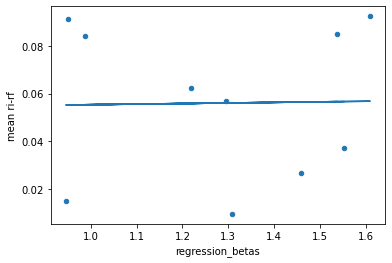

In [27]:
ax = dftot.plot(kind='scatter', x='regression_betas', y='mean ri-rf')
ax.plot(dftot.regression_betas, OLS_regr.predict());

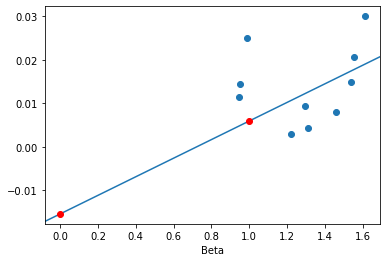

In [28]:
x1, y1 = 0, rf
x2, y2 = 1, average_market_ret
plt.axline((x1, y1), (x2, y2));
plt.plot(x1, y1, x2, y2, marker='o', color='red');
plt.scatter(*zip(*mean_ret_beta), marker='o')
plt.xlabel('Beta')
plt.show()

In [29]:
y1 = dftot['m_expected_returns']
X1 = sm.add_constant(dftot.regression_betas)
OLS_regr1 = sm.OLS(y1, X1).fit()
y2 = dftot['m_mean_returns']
X2 = sm.add_constant(dftot.regression_betas)
OLS_regr2 = sm.OLS(y2, X2).fit()
OLS_regr2.summary()

C:\Users\bergi\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         m_mean_returns   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.082
Method:                 Least Squares   F-statistic:                    0.3150
Date:                Wed, 21 Dec 2022   Prob (F-statistic):              0.590
Time:                        12:57:36   Log-Likelihood:                 33.813
No. Observations:                  10   AIC:                            -63.63
Df Residuals:                       8   BIC:                            -63.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0055      0.016      0.348      0.737      -0.031       0.042
regression_betas     0.0067      0.012      0.561      0.590      -0.021       0.034
==============================================================================
Omnibus:                        0.827   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.661   Jarque-Bera (JB):                0.695
Skew:                           0.395   Prob(JB):                        0.706
Kurtosis:                       1.979   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

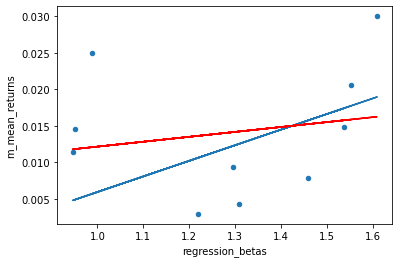

In [30]:
ax = dftot.plot(kind='scatter', x='regression_betas', y='m_mean_returns')
ax.plot(dftot.regression_betas, OLS_regr1.predict());
ax.plot(dftot.regression_betas, OLS_regr2.predict(), color='red');

# Minimum varaince frontier and optimal portfolio

In [31]:
x = np.zeros(10)

In [32]:
df = pd.DataFrame()
for i in stocks:
    stock = yf.download(i, start, end, progress = False)
    stock_close = stock['Adj Close']
    df[i] = stock_close.pct_change()

In [33]:
df_ind_rets = df.mean()*253
df_ind_rets

STLA.MI    0.285959
ENEL.MI    0.180129
ENI.MI     0.051108
ISP.MI     0.123518
RACE.MI    0.324403
STM.MI     0.372715
G.MI       0.142721
UCG.MI     0.097131
CNHI.MI    0.198028
ATL.MI     0.041556
dtype: float64

In [34]:
df_ind_std = df.std() * (253**0.5)
df_ind_std

STLA.MI    0.391415
ENEL.MI    0.239369
ENI.MI     0.283124
ISP.MI     0.301561
RACE.MI    0.274977
STM.MI     0.403145
G.MI       0.212023
UCG.MI     0.386038
CNHI.MI    0.364134
ATL.MI     0.381100
dtype: float64

In [35]:
cov_matrix = df.cov() * 253
cov_matrix

,STLA.MI,ENEL.MI,ENI.MI,ISP.MI,RACE.MI,STM.MI,G.MI,UCG.MI,CNHI.MI,ATL.MI
STLA.MI,0.153206,0.038977,0.060309,0.066275,0.049612,0.073488,0.046339,0.077835,0.081617,0.054129
ENEL.MI,0.038977,0.057298,0.036450,0.039346,0.028935,0.037981,0.028176,0.042733,0.036229,0.039729
ENI.MI,0.060309,0.036450,0.080159,0.058243,0.031186,0.047366,0.041558,0.064965,0.056961,0.046986
ISP.MI,0.066275,0.039346,0.058243,0.090939,0.032626,0.050986,0.043691,0.090300,0.061278,0.047866
RACE.MI,0.049612,0.028935,0.031186,0.032626,0.075612,0.054741,0.024531,0.035721,0.044626,0.032008
STM.MI,0.073488,0.037981,0.047366,0.050986,0.054741,0.162526,0.039219,0.059448,0.072592,0.049684
G.MI,0.046339,0.028176,0.041558,0.043691,0.024531,0.039219,0.044954,0.054568,0.043500,0.035829
UCG.MI,0.077835,0.042733,0.064965,0.090300,0.035721,0.059448,0.054568,0.149025,0.073973,0.056085
CNHI.MI,0.081617,0.036229,0.056961,0.061278,0.044626,0.072592,0.043500,0.073973,0.132594,0.057598
ATL.MI,0.054129,0.039729,0.046986,0.047866,0.032008,0.049684,0.035829,0.056085,0.057598,0.145237


In [36]:
def min_std(x, cov_matrix, bounds, args, ret):
    def objective_function(x, cov_matrix):
        return (x @ cov_matrix @ np.transpose(x))**0.5
    
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1},
               {'type':'eq', 'fun': lambda x: sum(x*df_ind_rets) - ret}
              )
    
    res = optimize.minimize(objective_function, x, args=args, method='SLSQP', constraints=constraints, bounds=bounds)
    return res.fun, res.x

In [37]:
args = (cov_matrix,)
bounds = Bounds(-2, 2)

In [38]:
wgt = []
opt_std = []
for i in np.arange(0.05, 0.7, 0.01):
    m = min_std(x, cov_matrix, bounds, args, ret=i)
    opt_std.append(m[0])
    wgt.append(m[1])

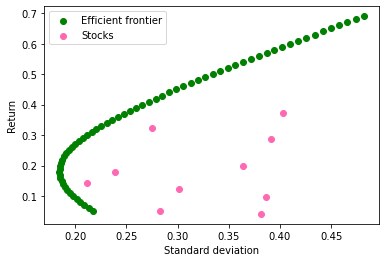

In [39]:
plt.scatter(opt_std, np.arange(0.05, 0.7, 0.01), c='green');
plt.scatter(df_ind_std, df_ind_rets, c='hotpink')
plt.xlabel('Standard deviation')
plt.ylabel('Return');
plt.legend(['Efficient frontier', 'Stocks']);

In [40]:
i = np.arange(0.05, 0.7, 0.01)

In [41]:
dta = pd.DataFrame({'ret': i, 'weights':wgt, 'stand':opt_std})

In [42]:
dta

,ret,weights,stand
0,0.05,"[-0.18496203542264733, 0.21790362120751863, 0....",0.217787
1,0.06,"[-0.1754961337523139, 0.22224408556549205, 0.3...",0.213271
2,0.07,"[-0.16619120316022162, 0.22697609275180813, 0....",0.209025
3,0.08,"[-0.15674441729704458, 0.2313273074283665, 0.2...",0.205065
4,0.09,"[-0.1472551703390083, 0.23556837774501743, 0.2...",0.201408
...,...,...,...
60,0.65,"[0.37960154144885433, 0.47894336180991337, -1....",0.449769
61,0.66,"[0.3890255151001333, 0.48330954259761855, -1.1...",0.457772
62,0.67,"[0.3984486492274187, 0.4877067929488428, -1.17...",0.465801
63,0.68,"[0.4078675001195433, 0.4921773841231583, -1.19...",0.473857


In [43]:
optimal_portfolio = dta.iloc[((dta.ret - rf)/dta.stand).idxmax()]

In [44]:
optimal_portfolio

ret                                                     0.41
weights    [0.15405346621636026, 0.3771123259593207, -0.5...
stand                                               0.272107
Name: 36, dtype: object

In [45]:
optimal_portfolio.weights

array([ 0.15405347,  0.37711233, -0.54589183,  0.04229705,  0.5895792 ,
        0.19975493,  0.59278258, -0.20928293, -0.00617702, -0.19422776])